In [1]:
import pandas as pd
import numpy as np

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [3]:
!wget $data 

--2024-10-07 12:07:05--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: 'laptops.csv.4'

     0K .......... .......... .......... .......... .......... 17% 2.67M 0s
    50K .......... .......... .......... .......... .......... 34% 4.49M 0s
   100K .......... .......... .......... .......... .......... 51% 3.70M 0s
   150K .......... .......... .......... .......... .......... 68% 5.26M 0s
   200K .......... .......... .......... .......... .......... 85% 3.74M 0s
   250K .......... .......... .......... .......... .         100% 5.06M=0.07s

2024-10-07 12:07:05 (3.92 MB/s) - 'laptops.csv.4' saved [298573/298573]



In [4]:
df = pd.read_csv('laptops.csv.4')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


## 1. Data preparation

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.head(5)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [8]:
columns = ['ram', 'storage', 'screen', 'final_price']

In [9]:
df = df[columns]

In [10]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


## 2. Exploratory data analysis

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

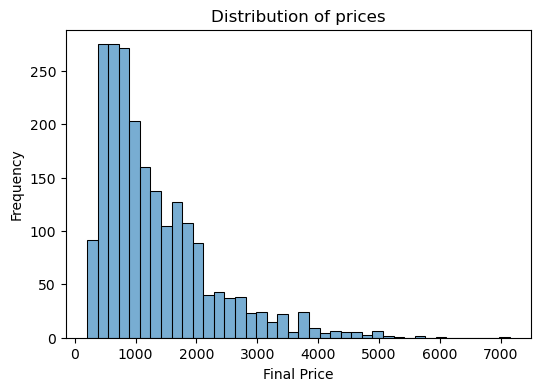

In [12]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=40, alpha=0.6)
plt.ylabel('Frequency')
plt.xlabel('Final Price')
plt.title('Distribution of prices')

plt.show()

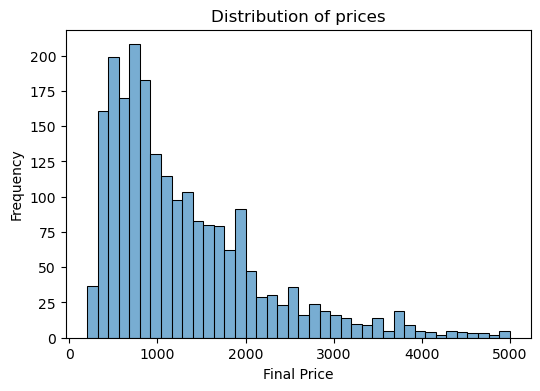

In [13]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price[df.final_price<5000], bins=40, alpha=0.6)
plt.ylabel('Frequency')
plt.xlabel('Final Price')
plt.title('Distribution of prices')

plt.show()

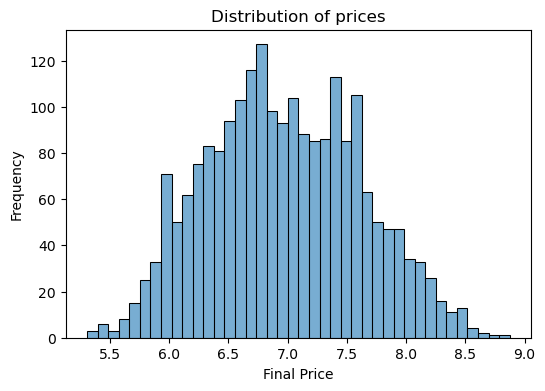

In [14]:
log_price = np.log1p(df.final_price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, alpha=0.6)
plt.ylabel('Frequency')
plt.xlabel('Final Price')
plt.title('Distribution of prices')

plt.show()

In [15]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [16]:
df.ram.median()

16.0

## 3. Validation framework

In [25]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [26]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## 4. Linear Regression

In [27]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

## 5. Option 1 - Filling missing values with 0

In [28]:
base = ['ram', 'storage', 'screen']

In [29]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [30]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [31]:
y_pred = w_0 + X_train.dot(w)

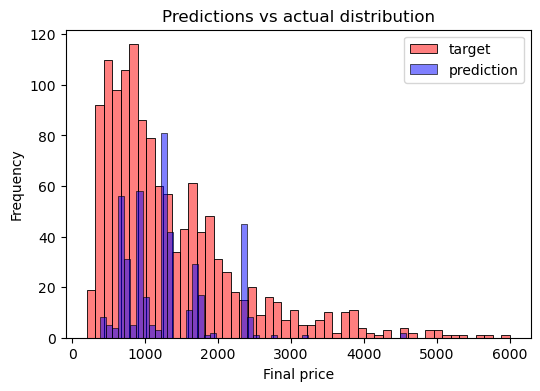

In [37]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.5, bins=50)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Final price')
plt.title('Predictions vs actual distribution')

plt.show()

In [33]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse),2)

In [34]:
print('train:', rmse(y_train, y_pred))

train: 602.39


In [35]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [36]:
print('validation:', rmse(y_val, y_pred))

validation: 597.36


## 6. Option 2 - Filling missing values with mean

In [38]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(value = df_train["screen"].mean())
    X = df_num.values
    return X

In [39]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [40]:
y_pred = w_0 + X_train.dot(w)

In [41]:
print('train:', rmse(y_train, y_pred))

train: 602.18


In [42]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [43]:
print('validation:', rmse(y_val, y_pred))

validation: 600.27


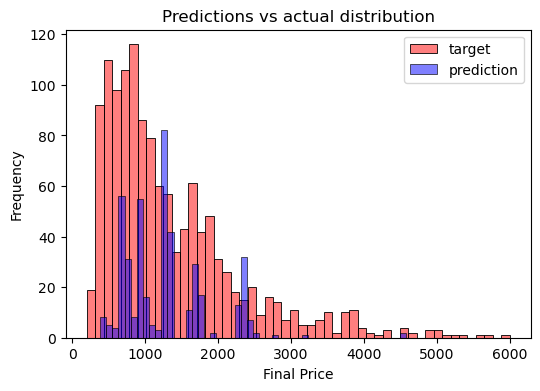

In [44]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.5, bins=50)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Final Price')
plt.title('Predictions vs actual distribution')

plt.show()

## 7. Regularization with missing values filled by 0

In [45]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [46]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [47]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 597.36
  0.01 597.36
   0.1 597.35
     1 597.21
     5 597.01
    10 597.06
   100 597.9


## 8. Different seeds

In [56]:
def train_linear_regression_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [57]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse),2)

In [58]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [61]:
scores = np.array([])

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    n = len(df)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    idx = np.arange(n)
    
    np.random.seed(i)
    np.random.shuffle(idx)

    # do the train/validation/test split with 60%/20%/20% distribution.
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # Fill the missing values with 0 and train a model without regularization.
    X_train = df_train.fillna(0).values

    # For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    scores = np.append(scores, score)
    
    print(i, score)


0 565.45
1 636.8
2 588.96
3 597.81
4 571.96
5 573.24
6 647.34
7 550.44
8 587.33
9 576.1


In [62]:
print(scores)

[565.45 636.8  588.96 597.81 571.96 573.24 647.34 550.44 587.33 576.1 ]


In [63]:
std = round(np.std(scores), 3)
print(std)

29.176


## 9. Question 6

In [64]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [65]:
idx = np.arange(n)

In [66]:
np.random.seed(9)
np.random.shuffle(idx)

In [67]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [68]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [69]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [70]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [71]:
df_full_train = pd.concat([df_train, df_val])

In [72]:
df_full_train = df_full_train.reset_index(drop=True)

In [73]:
X_full_train = prepare_X(df_full_train)

In [74]:
y_full_train = np.concatenate([y_train, y_val])

In [75]:
def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [76]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train)

In [77]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

608.61